In [1]:
# Note: Original saved in Tahir Sproj

# Deep Learning Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data

# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt

# File and System Interaction
import os
from pathlib import Path
import shutil
import torch.optim as optim


# Date and Time Handling
import time
import datetime

# Linear Algebra
from torch import linalg as LA

# Neural Architecture
try:
    from torchinfo import summary
except:
    # %pip install torchinfo
    from torchinfo import summary

In [2]:
%load_ext autoreload
%autoreload 2

from python_scripts import dataset_processing
from python_scripts import architecture
from python_scripts import revised_architecture
from python_scripts import training
from python_scripts import logs_and_results

In [3]:
# Setting up some global variables

ROOT = 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/ConvHuberMC/HuberMC_Data'
# ROOT = 'C:/Users/HP/GitHub Workspace/ConvHuberMC-Net/HuberMC_Data'
TRY = 'Try 1'
SESSION = 'Session 1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#### Model path of loading

Testing Training Loop

In [4]:
# Get parameters --> for convhubermc: c, lambda, sigma, mu, delta, tau
def get_default_param(gpu = True):
    params_net = {}
    params_net['size1'] = 150
    params_net['size2'] = 300
    params_net['rank'] = 10
    
    params_net['device'] = device

    params_net['hubreg_iters'] = 2
    params_net['layers'] = 3
    params_net['kernel'] = (3, 3)
    
    params_net['CalInGPU'] = gpu
    
    return params_net

In [5]:
# seed = 123
# torch.manual_seed(seed)
# target = (torch.randn(30, 50))
# input_tensor = target * torch.bernoulli(torch.full((30, 50), 0.2))
# model = architecture.UnfoldedNet_Huber(params = get_default_param(False))

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters())

# model.train()
# output = model(input_tensor)

# loss = (criterion(output, target))/torch.square(torch.norm(target, p = 'fro'))
# optimizer.zero_grad()
# print(f'loss before backward: {loss}, loss.grad: {loss.requires_grad}')
# loss.backward()
# print(f'loss: {loss}')
# print("\nGradients after one epoch:")
# for name, param in model.named_parameters():
#     print(f'name: {name}\t\tgradient: {param.grad}')
# optimizer.step()

In [6]:
# # Create a input_tensor of random indices
# shuffled_indices = torch.randperm(input_tensor.nelement())

# # Index the original input_tensor with these shuffled indices
# shuffled_input_tensor = input_tensor.view(-1)[shuffled_indices].view(input_tensor.size())

# output = model(shuffled_input_tensor)

# loss = (criterion(output, target))/torch.square(torch.norm(target, p = 'fro'))
# optimizer.zero_grad()
# print(f'loss before backward: {loss}, loss.grad: {loss.requires_grad}')
# loss.backward()
# print(f'loss: {loss}')
# print("\nGradients after one epoch:")
# for name, param in model.named_parameters():
#     print(f'name: {name}\t\tgradient: {param.grad}')
# optimizer.step()

In [7]:
# # Create a input_tensor of random indices
# shuffled_indices = torch.randperm(input_tensor.nelement())

# # Index the original input_tensor with these shuffled indices
# shuffled_input_tensor = input_tensor.view(-1)[shuffled_indices].view(input_tensor.size())

# output = model(shuffled_input_tensor)

# loss = (criterion(output, target))/torch.square(torch.norm(target, p = 'fro'))
# optimizer.zero_grad()
# print(f'loss before backward: {loss}, loss.grad: {loss.requires_grad}')
# loss.backward()
# print(f'loss: {loss}')
# print("\nGradients after one epoch:")
# for name, param in model.named_parameters():
#     print(f'name: {name}\t\tgradient: {param.grad}')
# optimizer.step()

In [8]:
model = revised_architecture.UnfoldedNet_Huber(params = get_default_param(False))
model

UnfoldedNet_Huber(
  (conv_layers): ModuleList(
    (0-449): 450 x Conv2dC(
      (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (huber_obj): Sequential(
    (0): Huber(
      (conv_layers): ModuleList(
        (0-449): 450 x Conv2dC(
          (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (1): Huber(
      (conv_layers): ModuleList(
        (0-449): 450 x Conv2dC(
          (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
    (2): Huber(
      (conv_layers): ModuleList(
        (0-449): 450 x Conv2dC(
          (convR): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
    )
  )
)

In [9]:
# model.forward(torch.randn(150, 300) * torch.bernoulli(torch.full((150, 300), 0.2)))
# model.forward(torch.randn(30, 50) * torch.bernoulli(torch.full((30, 50), 0.2)))


In [10]:
summary(model, input_size = [150, 300])

Layer (type:depth-idx)                   Output Shape              Param #
UnfoldedNet_Huber                        [150, 300]                --
├─Sequential: 1-1                        [150, 300]                --
│    └─Huber: 2-1                        [150, 300]                4,500
│    └─Huber: 2-4                        --                        (recursive)
│    │    └─ModuleList: 3-3              --                        (recursive)
│    └─Huber: 2-3                        [150, 300]                4,500
│    └─Huber: 2-4                        --                        (recursive)
│    │    └─ModuleList: 3-3              --                        (recursive)
│    └─Huber: 2-5                        [150, 300]                4,500
│    │    └─ModuleList: 3-3              --                        (recursive)
Total params: 17,990
Trainable params: 17,990
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 27
Input size (MB): 0.18
Forward/backward pass size (MB): 21.60
Pa

Project Name: Try 1 HuberMC-Net Q 80.0% DB 3.0

Configuring Network...
Instantiating Model...
Model Instantiated...

Parameters = 
{'size1': 150, 'size2': 300, 'rank': 10, 'device': 'cpu', 'hubreg_iters': 2, 'layers': 3, 'kernel': (3, 3), 'CalInGPU': False}

Epoch: 1, 2024-03-23 19:07:35, 

Epoch [1/20], Mean Training Loss:5.82097e-07, Mean Validation Loss:1.68410e-01
Epoch: 2, 2024-03-23 19:09:50, 

Epoch [2/20], Mean Training Loss:5.25937e-07, Mean Validation Loss:2.08479e-01
Epoch: 3, 2024-03-23 19:11:48, 

Epoch [3/20], Mean Training Loss:5.43814e-07, Mean Validation Loss:2.12279e-01
Epoch: 4, 2024-03-23 19:13:50, 

Epoch [4/20], Mean Training Loss:5.20960e-07, Mean Validation Loss:2.27212e-01
Epoch: 5, 2024-03-23 19:15:45, 

Epoch [5/20], Mean Training Loss:4.87079e-07, Mean Validation Loss:1.62318e-01
Saving Whole Model at Epochs: [5/20]
Saving Model Dict at Epochs: [5/20]
Epoch: 6, 2024-03-23 19:17:36, 

Epoch [6/20], Mean Training Loss:4.66258e-07, Mean Validation Loss:1.50084e

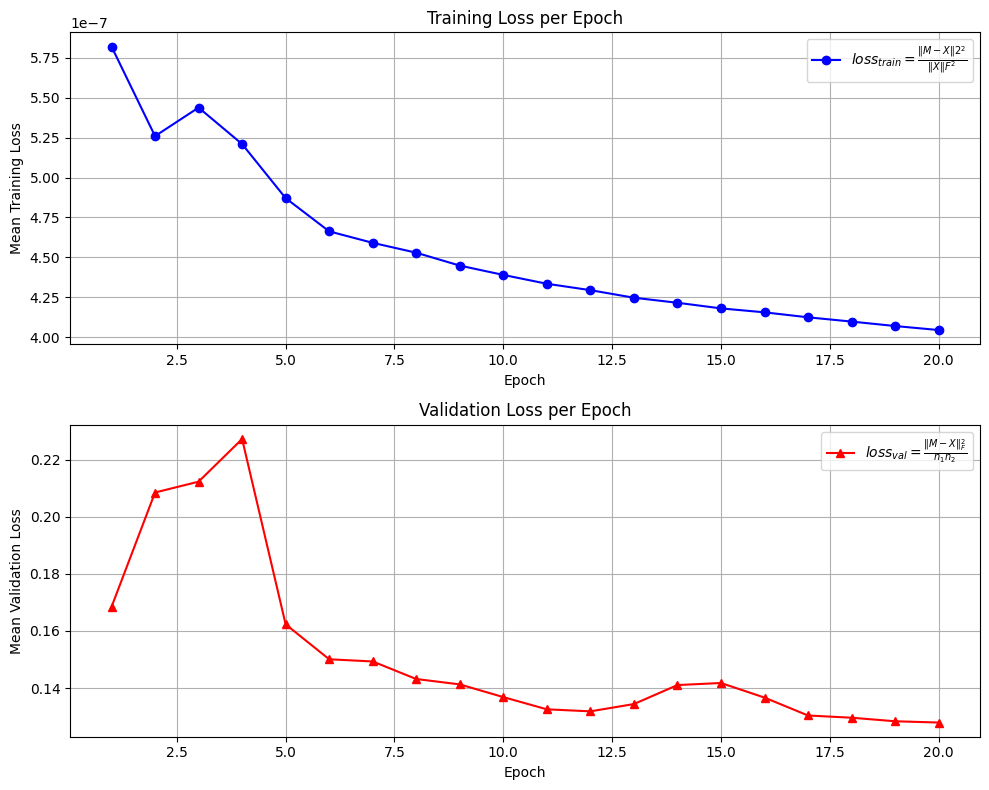

<Figure size 640x480 with 0 Axes>

In [11]:
# Some settings for visualisation
matplotlib.use('Agg')
%matplotlib inline

seed = 123
torch.manual_seed(seed)

# Set parameters (including hyperparameters) and setting for saving/logging data
hyper_param_net = training.get_hyperparameter_grid('HuberMC-Net', TrainInstances = 20, ValInstances = 10, BatchSize = 5, ValBatchSize = 2, num_epochs = 20, learning_rate = 0.001)
params_net = get_default_param(gpu = False)
CalInGPU = params_net['CalInGPU']

q_list = [0.2]
db_list = [5.0]

for q in q_list:
    for db in db_list:
        # ProjectName = TRY + ' ' + logs_and_results.get_current_time() + ' ' + hyper_param_net['Model'] + ' ' + 'Sampling Rate: ' + logs_and_results.get_q_str(q) + ' and DB ' + logs_and_results.get_noise_str(db)

        ProjectName = TRY + ' ' + hyper_param_net['Model'] + ' Q ' + logs_and_results.get_q_str(q) + ' DB ' + logs_and_results.get_noise_str(db)
        # Note: Removed time stamp from log file name as : not supported. Weird because this was not a problem in linux

        # Get log file
        logfile = logs_and_results.get_modularized_record(ProjectName, q, db, 'Logs', hyper_param_net, params_net, ROOT, SESSION)
        with open(logfile, 'w', 1) as log:
            print('Project Name: %s\n'%ProjectName)
            log.write('Project Name: %s\n\n'%ProjectName)

            # Get Model
            net = training.get_model(params_net, hyper_param_net, log)
            print('\nParameters = \n%s\n'%str(params_net))
            log.write('\nParameters = \n%s\n\n'%str(params_net))

            #Loading data and creating dataloader for both test and training
            # print('Loading Data phase...')
            log.write('Loading phase...\n')
            shape_dset = (params_net['size1'], params_net['size2'])
            
            train_loader, val_loader = dataset_processing.get_dataloaders(params_net = params_net, hyper_param_net = hyper_param_net, sampling_rate = q, db = db, ROOT = ROOT)

            # print('Finished loading.\n')
            log.write('Finished loading.\n\n')

            # Some additional settings for training including loss, optimizer,
            # floss = nn.functional.mse_loss(reduction = 'sum')
            floss = nn.MSELoss()
            optimizer = torch.optim.Adam(net.parameters(), lr = hyper_param_net['Lr'])
            # scheduler2 =  torch.optim.lr_scheduler.StepLR(optimizer, step_size= 1, gamma = 0.97, verbose = True)

            # Array for recording parameter values after each layer for each epoch etc
            outputs_L = revised_architecture.to_var(torch.zeros([shape_dset[0], shape_dset[1]]), CalInGPU) 
            lossmean_vec = np.zeros((hyper_param_net['Epochs'], ))
            lossmean_val_vec = np.zeros((hyper_param_net['Epochs'], ))


            # dummy variable to monitor and record progress for loss
            minloss = np.inf

            for epoch in range(hyper_param_net['Epochs']):
                print(f'Epoch: {epoch + 1}, {logs_and_results.get_current_time()}, \n')
                log.write(f'Epoch: {epoch + 1} ')
                log.write(logs_and_results.get_current_time() + '\n\n')

                # Train and Test Steps. (Record every 5 epochs)
                if (epoch + 1) % 5 == 0:
                    # print('Loading and calculating training batches...')
                    log.write('Loading and calculating training batches...\n')
                    startime = time.time()
                    loss_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize']) # remove alpha from train func
                    endtime = time.time()
                    # print('Training time is %f'%(endtime - startime))
                    log.write('Training time is %f'%(endtime - startime))

                    # print('Loading and calculating validation batches...')
                    log.write('Loading and calculating validation batches...\n')
                    startime = time.time()
                    loss_val_mean = training.test_step(net, val_loader, floss, CalInGPU, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])
                    endtime = time.time()
                    # print('Test time is %f'%(endtime - startime))
                    log.write('Test time is %f'%(endtime - startime))

                else:
                    loss_mean = training.train_step(net, train_loader, floss, optimizer, CalInGPU, hyper_param_net['TrainInstances'], hyper_param_net['BatchSize'])
                    loss_val_mean = training.test_step(net, val_loader, floss, CalInGPU, hyper_param_net['ValInstances'], hyper_param_net['ValBatchSize'])

                # Update Record and Parameters
                lossmean_vec[epoch] = loss_mean
                lossmean_val_vec[epoch] = loss_val_mean


                print('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e'
                      %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))

                # Update Log after every 5 epochs. Make a plot of MSE against epochs every 5 epochs. Save Model in whole/dict form every five epochs.
                if (epoch + 1) % 5 == 0:
                    print(f"Saving Whole Model at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
                    model_whole_path = logs_and_results.get_modularized_record(ProjectName, q, db, 'Saved Models - Whole', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
                    # torch.save(net, model_whole_path)
                    print(f"Saving Model Dict at Epochs: [{epoch + 1}/{hyper_param_net['Epochs']}]")
                    model_state_dict_path = logs_and_results.get_modularized_record(ProjectName, q, db, 'Saved Models - Dict', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
                    # torch.save(net.state_dict(), model_state_dict_path)

                    # print('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e'
                    # %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
                    # print('loss_lowrank_mean', loss_lowrank_mean)
                    # print('loss_val_lowrank_mean', loss_val_lowrank_mean)
                    # print(f'c: {c_list}, lamda: {lamda_list}, mu: {mu_list}')

                    # log.write('loss_lowrank_mean %.5e\n' %(loss_lowrank_mean))
                    # log.write('loss_val_lowrank_mean %.5e\n' %(loss_val_lowrank_mean))
                    log.write('Epoch [%d/%d], Mean Training Loss:%.5e, Mean Validation Loss:%.5e\n'
                              %(epoch + 1, hyper_param_net['Epochs'], loss_mean, loss_val_mean))
                    np.set_printoptions(precision = 3)

                    if True or loss_val_mean < minloss:
                        # print('saved at [epoch%d/%d]'%(epoch + 1, hyper_param_net['Epochs']))
                        log.write('saved at [epoch%d/%d]\n' %(epoch + 1, hyper_param_net['Epochs']))
                        minloss = min(loss_val_mean, minloss)

            # Finish off by observing the minimum loss on validation set

            #Print min loss
            # print('\nMin Loss = %.4e'%np.min(lossmean_val_vec))
            log.write('\nMin Loss = %.4e'%np.min(lossmean_val_vec))

            # Plotting MSE vs Epoch and Saving it

            # Get Directory where we have to save the plot
            dir = logs_and_results.get_modularized_record(ProjectName, q, db, 'Plots', hyper_param_net, params_net, ROOT, SESSION, current_epoch = epoch + 1)
            logs_and_results.plot_and_save_mse_vs_epoch(lossmean_vec, lossmean_val_vec, dir)